In [3]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install tenserflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow


In [4]:
# Loading data
data = pd.read_csv('goog.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    61 non-null     object 
 1   Open    61 non-null     float64
 2   High    61 non-null     float64
 3   Low     61 non-null     float64
 4   Close   61 non-null     float64
 5   Volume  61 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.0+ KB


In [11]:
# Selecting only Date and Average Price columns
data['average'] = (data['High'] + data['Low']) / 2

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     61 non-null     object 
 1   Open     61 non-null     float64
 2   High     61 non-null     float64
 3   Low      61 non-null     float64
 4   Close    61 non-null     float64
 5   Volume   61 non-null     int64  
 6   average  61 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.5+ KB


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     61 non-null     object 
 1   Open     61 non-null     float64
 2   High     61 non-null     float64
 3   Low      61 non-null     float64
 4   Close    61 non-null     float64
 5   Volume   61 non-null     int64  
 6   average  61 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.5+ KB


In [16]:
# Selecting only Date and Average Price columns
data = data[['Date', 'average']]


In [18]:
# Scaling the values in the range of 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_price = scaler.fit_transform(data.loc[:, 'average'].values.reshape(-1, 1))


In [19]:
# Splitting dataset in the ratio of 75:25 for training and test
train_size = int(data.shape[0] * 0.75)
train, test = scaled_price[0:train_size, :], scaled_price[train_size:data.shape[0], :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (45, 16)


In [20]:
def create_dataset(scaled_price, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(scaled_price) - window_size - 1):
        a = scaled_price[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(scaled_price[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))


In [21]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)


Original training data shape:
(41, 3)
New training data shape:
(41, 1, 3)


In [22]:
# Designing the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")
# Training the model
model.fit(train_X, train_Y, epochs=3, batch_size=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1157
Epoch 2/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0368


In [23]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)
print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Training data score: 14.44 RMSE
Test data score: 27.78 RMSE


In [24]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)
print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Training data score: 14.44 RMSE
Test data score: 27.78 RMSE


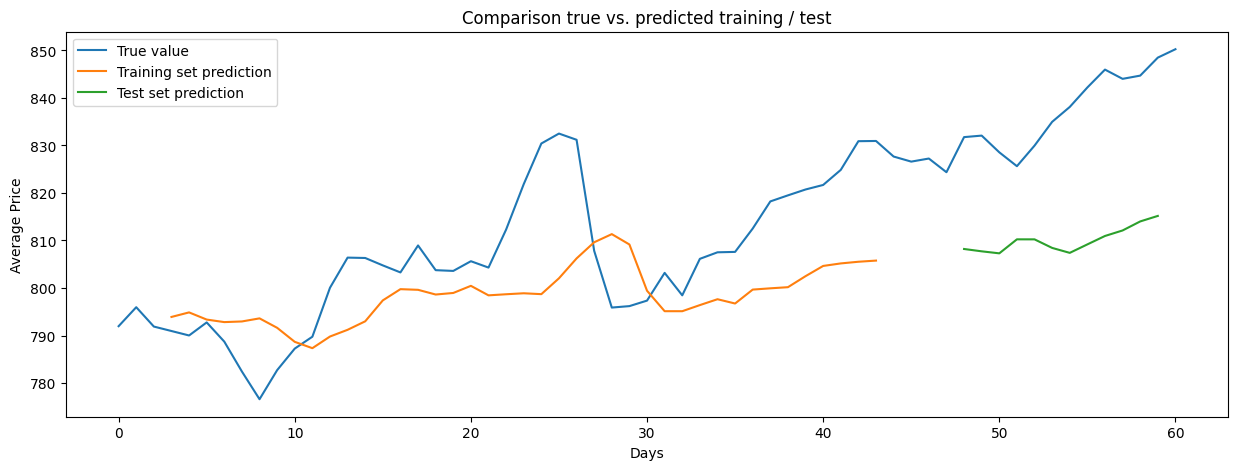

In [25]:
# Start with training predictions.
train_predict_plot = np.empty_like(scaled_price)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict
# Add test predictions.
test_predict_plot = np.empty_like(scaled_price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(scaled_price) - 1, :] = test_predict
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled_price), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()
